In [39]:
import numpy as np
import pandas as pd
import time
import random
import matplotlib.pyplot as plt
import math
import copy

In [40]:
df_distancias = pd.read_csv("../Datos/Caso II - Matriz de Distancias.csv", delimiter= ",", index_col= 0)
dist_matrix = df_distancias.values
ubicacion_clientes = pd.read_csv("../Datos/Caso II - Ubicacion Clientes.csv", delimiter= ",", index_col= 0)
datos_prueba = pd.read_csv("../Datos/Caso II - Set de Datos.csv", delimiter= ",", index_col= 0)
test_data = datos_prueba.values

In [41]:
column_mapping = {column_name: int(column_name) for column_name in datos_prueba.columns}

# Reassign columns with new integer names
datos_prueba.rename(columns=column_mapping, inplace=True)

In [42]:
#DEFINO LA MATRIZ LLEGA
def llega(x):
   return True if x <= 2 else False

df_llega = df_distancias.applymap(llega)

In [43]:
#DEFINIMOS CONSTANTES
#PROBLEMA
TARIFA_PROMEDIO = 1200
AHORRO = 0.05
TARIFA_OBJETIVO = TARIFA_PROMEDIO * (1-AHORRO)
CANTIDAD_DE_CLIENTES_POR_CAMION = 3
CANTIDAD_DE_CAMIONES = 6
TONS_MAX_POR_CAMION = 12
#METAHEURISTICA
CANTIDAD_DE_PEDIDOS_CAMBIAR = 3

In [44]:
#FUNCIONES
#generarSolucionInicial
def generarSolucionInicial(pedidos): #PEDIDOS ES UNA PANDAS SERIES CON LOS PEDIDOS
    #-----------------------CAMBIAR DATOS_PRUEBA 2 ----------------------------------------------------------------------
    pedidos = pedidos[pedidos > 0 ].index #Elimina los clientes con 0 toneladas y toma el index(Nombre de los clientes)
    pedidos = pedidos.to_list() #Lo convierte a lista
    pedidos.pop() #Elimino el ultimo (el total)
    pedidos_por_asignar = pedidos #Asigno todos lo pedidos a pedidos por asignar
    clientes_por_camion = [[] for _ in range(CANTIDAD_DE_CAMIONES)] #Armo la lista con los pedidos de los camiones por cliente
    pedidos_no_asignados = [] #Inicializo un lista con pedidos no asignados
    cantidad_clientes = len(pedidos_por_asignar) 
    for i in range(cantidad_clientes): #Recorro toda la lista de clientes para ese dia
        cliente = pedidos_por_asignar.pop() #Elimino el ultimo cliente de la lista de clientes a la vez que le asigno el cliente eliminado a la variable cliente
        rand = random.randint(0, CANTIDAD_DE_CAMIONES-1) #genero un numero aleatorio entero del 0 al 5
        camion_cliente = clientes_por_camion[rand] #Elijo el camion al aleatoriamente
        cantidad_clientes = len(camion_cliente)
        if cantidad_clientes < CANTIDAD_DE_CLIENTES_POR_CAMION: #Verifico que el camion no tenga 3 clientes
            llega_list = []
            for cliente_en_camion in camion_cliente:
                llega = df_llega.loc[cliente_en_camion,cliente]
                llega_list.append(llega)
            llega_todos = all(llega_list) #Si da 0 es decir que hay al menos un false, entonces no llega a todos
            if(llega_todos):
                clientes_por_camion[rand].append(cliente)
            else:
                pedidos_no_asignados.append(cliente)
        else:
            pedidos_no_asignados.append(cliente)
    return clientes_por_camion, pedidos_no_asignados #Devuelve dos listas ej: ([['A', 'B'],['J', 'H','D'] ] ['C','E','F'])


#--------------------------------------------------------------------------------------------------------------------


def pedidosPorCamion(clientes_por_camion, pedidos): #RECIBE UNA LISTA Y UN A PANDAS.SERIES DEVUELVE UNA LIST DE SERIES
    pedidos_por_camion = []
    for camion in clientes_por_camion: #Recorro los clientes por camion
            pedido = pedidos[camion] #Selecciono los pedidos de ese cliente(las tons)
            pedidos_por_camion.append(pedido)
    return pedidos_por_camion #Una lista de pandas.Series


#----------------------------------------------------------------------------------------------------------------------


#Calcular costo de la solucion
def tonsRepartidasPorCamion(pedidos_por_camion): #RECIBE UNA LIST DE SERIES Y DEVULEVE UNA LISTA DE NUMEROS
    tons = 0
    tons_repartidas_por_camion = []
    toneladas_no_repartidas = 0
    for pedido in pedidos_por_camion:
        tons = pedido.values.sum()
        if(tons <= TONS_MAX_POR_CAMION):
            tons_repartidas_por_camion.append(tons)
        else:
            tons_repartidas_por_camion.append(TONS_MAX_POR_CAMION)
            toneladas_no_repartidas += tons-TONS_MAX_POR_CAMION
    return tons_repartidas_por_camion, toneladas_no_repartidas


#--------------------------------------------------------------------------------------------------------------------------


#SUPER OK
def costoPorCamion(tons_repartidas_por_camion):
    costo_por_camion = []
    for tons in tons_repartidas_por_camion:
        costo = float(0)
        if (tons == 0):
            costo = 5000
        elif (tons < 4):
            costo = 5600
        elif (tons < 6.5):
            costo = tons * 1400
        elif (tons < 9.5):
            costo = tons * 1200
        else:
            costo = tons * 1000
        costo_por_camion.append(costo)
    return costo_por_camion


#-------------------------------------------------------------------------------------------------------------------------------------


def tonsNoAsignadas(pedidos_no_asignados, pedidos):
    return pedidos[pedidos_no_asignados].values.sum()

def costoTotal(costo_por_camion, tons_no_asignadas_o_no_repartidas):
    costo_total = sum(costo_por_camion) + tons_no_asignadas_o_no_repartidas * 3000
    return costo_total

def tonsRepartidas(tons_repartidas_por_camion):
    tons_repartidas = sum(tons_repartidas_por_camion)
    return tons_repartidas


In [45]:
def calcularCostoPorTon(cpc, cna, pedidos):
    #GENERA LOS PEDIDOS POR CAMION los pedidos(lista de Series) a partir de los clientes(lista de listas)
    pedidos_por_camion = []
    for camion in cpc: #Recorro los clientes por camion
            pedido = pedidos[camion] #Selecciono los pedidos de ese cliente(las tons)
            pedidos_por_camion.append(pedido)
    tons = 0
    tons_repartidas_por_camion = []
    

    #Calcula las toneladas que puede llevar cada camion y las que no
    tons_no_repartidas = 0
    for pedido in pedidos_por_camion:
        tons = pedido.values.sum()
        if(tons <= TONS_MAX_POR_CAMION):
            tons_repartidas_por_camion.append(tons)
        else:
            tons_repartidas_por_camion.append(TONS_MAX_POR_CAMION)
            tons_no_repartidas += tons-TONS_MAX_POR_CAMION
    
    #CALCULA EL COSTO A PARTIR DE LAS TONELADAS
    costo_por_camion = []
    for tons in tons_repartidas_por_camion:
        costo = float(0)
        if (tons == 0):
            costo = 5000
        elif (tons < 4):
            costo = 5600
        elif (tons < 6.5):
            costo = tons * 1400
        elif (tons < 9.5):
            costo = tons * 1200
        else:
            costo = tons * 1000
        costo_por_camion.append(costo)
    
    #CALCULA LAS TONS REPARTIDAS
    tons_repartidas = sum(tons_repartidas_por_camion)
    
    #CALCULA LAS TONS NO ASIGNADAS
    tons_no_asignadas = pedidos[cna].values.sum()

    #CALCULA EL TOTAL DE LAS TONS NO ASIGNADAD O REPARTIDAS
    tons_no_asignadas_o_no_repartidas = tons_no_asignadas + tons_no_repartidas

    #CALCULA EL COSTO TOTAL
    costo_total = sum(costo_por_camion) + tons_no_asignadas_o_no_repartidas * 3000

    #CALCULA EL COSTO POR TON
    costo_por_ton = costo_total/tons_repartidas
    
    return costo_por_ton


In [46]:
cpc = [['F'],['H','L'],['G','K'],['C','E'],['J','B','D'],['A','I']]
ped = datos_prueba[1]

calcularCostoPorTon(cpc,[],ped)

1386.3636363636363

In [47]:
cpc = [['F'],['H','L'],['G','K'],['C','E'],['J','B','D'],['A','I']]
ped = datos_prueba[1]
pedidos_por_camion = pedidosPorCamion(cpc, ped)
print("pedidos_por_camion:", pedidos_por_camion)
tons_repartidas_por_camion, tons_no_repartidas = tonsRepartidasPorCamion(pedidos_por_camion)
print("tons_repartidas_por_camion:", tons_repartidas_por_camion)
print("tons_no_repartidas:", tons_no_repartidas)
tons_no_asignadas = tonsNoAsignadas([], ped)
print("tons_no_asignadas:", tons_no_asignadas)
costo_por_camion = costoPorCamion(tons_repartidas_por_camion)
tons_no_asignadas_o_no_repartidas = tons_no_repartidas + tons_no_asignadas
print("tons_no_asignadas_o_no_repartidas:", tons_no_asignadas_o_no_repartidas)
#costo_por_camion = costoPorCamion(tons_repartidas_por_camion)
costo_total = costoTotal(costo_por_camion, tons_no_asignadas_o_no_repartidas)
print("costo_total:", costo_total)
tons_repartidas = tonsRepartidas(tons_repartidas_por_camion)
print("tons_repartidas:", tons_repartidas)
#CALCULO EL COSTO POR TON REPARTIDA
costo_por_ton_repartida_1 = costo_total/tons_repartidas

costo_por_ton_repartida_1


pedidos_por_camion: [Cliente
F    3
Name: 1, dtype: int64, Cliente
H    5
L    6
Name: 1, dtype: int64, Cliente
G    3
K    1
Name: 1, dtype: int64, Cliente
C    1
E    4
Name: 1, dtype: int64, Cliente
J    1
B    6
D    8
Name: 1, dtype: int64, Cliente
A    4
I    5
Name: 1, dtype: int64]
tons_repartidas_por_camion: [3, 11, 4, 5, 12, 9]
tons_no_repartidas: 3
tons_no_asignadas: 0
tons_no_asignadas_o_no_repartidas: 3
costo_total: 61000
tons_repartidas: 44


1386.3636363636363

In [48]:
def generarVecino1(clpc, clpa): #Recibe una list de lists y una list
    cpc = copy.deepcopy(clpc)
    cpa = copy.deepcopy(clpa)
    #---------SACA UN PEDIDO POR CAMION----------

    for clientes_por_camion_i in cpc:
        len_i = len(clientes_por_camion_i) #Veo cuantos pedidos tiene el camion
        if(len_i > 0):
            rand = random.randint(0, len_i-1) #Selecciono el pedido a cambiar
            cliente_eliminado = clientes_por_camion_i.pop(rand)
            #print("Cliente eliminado: ", cliente_eliminado)
            cpa.append(cliente_eliminado)
    
    #------AGREGA LOS PEDIDOS ALEATORIAMENTE A LOS CAMIONES------

    pna = []
    cantidad_pedidos_por_asignar = len(cpa)
    for i in range(cantidad_pedidos_por_asignar):
        cliente_a_asignar = cpa.pop()
        rand = random.randint(0, CANTIDAD_DE_CAMIONES-1)
        camion = cpc[rand]
        cantidad_clientes = len(camion)
        if  cantidad_clientes < CANTIDAD_DE_CLIENTES_POR_CAMION:
            llega_list = []
            for cliente_en_camion in camion:
                llega = df_llega.loc[cliente_en_camion,cliente_a_asignar]
                llega_list.append(llega)
            llega_todos = all(llega_list)
            if(llega_todos):
                cpc[rand].append(cliente_a_asignar)
            else:
                pna.append(cliente_a_asignar)
        else:
            pna.append(cliente_a_asignar)
    return  cpc, pna #Devuelve una list de lists y una list



In [50]:
import random
clpc_1 = [['F'],['H','L'],['G','K'],['C','E'],['J','B','D'],['A','I']]
pna_1 = []
clpc = None
pna = None

for i in range(100):
    print("\n--------------",i,"------------------")
    print("---Antes de generarVecino1---")
    print("clpc", clpc)
    print("pna", pna)
    print("clpc_1", clpc_1)
    print("pna_1", pna_1)
    print("---generar vecino---")
    clpc, pna = generarVecino1(clpc_1,pna_1)
    print("---Despues de generarVecino1---")
    print("clpc:",clpc)
    print("pna:",pna)
    print("clpc_1:", clpc_1)
    print("pna_1:", pna_1)
    if random.randint(0,1):
        print("---Ingresa al if---")
        clpc_1 = clpc
        pna_1  = pna
        print("---Despues del if---")
        print("clpc")
        print("clpc_1 despues del if", clpc_1)
        print("pna_1 despues del if", pna)

        
clpc, pna


-------------- 0 ------------------
---Antes de generarVecino1---
clpc None
pna None
clpc_1 [['F'], ['H', 'L'], ['G', 'K'], ['C', 'E'], ['J', 'B', 'D'], ['A', 'I']]
pna_1 []
---generar vecino---
---Despues de generarVecino1---
clpc: [['F'], ['L', 'A'], ['K', 'G'], ['E', 'D'], ['J', 'B'], ['I', 'C']]
pna: ['H']
clpc_1: [['F'], ['H', 'L'], ['G', 'K'], ['C', 'E'], ['J', 'B', 'D'], ['A', 'I']]
pna_1: []

-------------- 1 ------------------
---Antes de generarVecino1---
clpc [['F'], ['L', 'A'], ['K', 'G'], ['E', 'D'], ['J', 'B'], ['I', 'C']]
pna ['H']
clpc_1 [['F'], ['H', 'L'], ['G', 'K'], ['C', 'E'], ['J', 'B', 'D'], ['A', 'I']]
pna_1 []
---generar vecino---
---Despues de generarVecino1---
clpc: [[], ['H'], ['K'], ['C', 'E'], ['J', 'B', 'D'], ['I', 'A', 'L']]
pna: ['G', 'F']
clpc_1: [['F'], ['H', 'L'], ['G', 'K'], ['C', 'E'], ['J', 'B', 'D'], ['A', 'I']]
pna_1: []

-------------- 2 ------------------
---Antes de generarVecino1---
clpc [[], ['H'], ['K'], ['C', 'E'], ['J', 'B', 'D'], ['I', 

([['A'], ['L', 'B', 'C'], [], ['K'], ['F', 'I', 'D'], ['H', 'G']], ['J', 'E'])

In [51]:
def popi(a):
    b = a
    b.pop()

In [52]:
a = [1,2,3,4]
popi(a)
print(a)

[1, 2, 3]


In [53]:
def recocidoSimulado1(pedidos):
    t_start = time.time()
    clientes_por_camion_min = []
    pedidos_no_asignados_min = []
    costo_por_ton_repartida_min = float('inf')
    pedidos_no_asignados = None

    #GENERO SOLUCION INICIAL
    clientes_por_camion_1, pedidos_no_asignados_1 = generarSolucionInicial(pedidos)

    #CALCULO EL COSTO POR TON
    #cptr costo por tonelada repartida
    costo_por_ton_repartida_1 = calcularCostoPorTon(clientes_por_camion_1, pedidos_no_asignados_1, pedidos)
    
    #ASIGNO LOS CLIENTES POR CAMION, LOS CLIENTES NO ASIGNADOS, Y EL COSTO POR TON REPARTIDA
    clientes_por_camion_min = clientes_por_camion_1
    pedidos_no_asignados_min = pedidos_no_asignados_1
    costo_por_ton_repartida_min = costo_por_ton_repartida_1

    list_costo_temp_min = [costo_por_ton_repartida_min]
    list_costo_tiempo_min = [costo_por_ton_repartida_min]
    t_sol_inicial = time.time()
    list_tiempo = [t_sol_inicial - t_start]
    for t in range(T_INICIAL, T_FINAL, PASO):

        for n in range(ITERACIONES_POR_TEMPERATURA):
            #GENERO SOLUCION INICIAL
            clientes_por_camion, pedidos_no_asignados = generarVecino1(clientes_por_camion_1, pedidos_no_asignados_1)

            #CALCULO EL COSTO POR TON
            #cptr costo por tonelada repartida
            costo_por_ton_repartida = calcularCostoPorTon(clientes_por_camion, pedidos_no_asignados, pedidos)
            

            #PROCESO DE DECISION
            delta = costo_por_ton_repartida_1 - costo_por_ton_repartida #Calculo delta como Sa - Sb

            #SOLUCION PEOR QUE EN LA ITERACION ANTERIOR
            if delta < 0 : #Si la solucion nueva es peor que la anterio delta < 0
                
                p = math.e**(delta/t)
                rand_0_1 = random.random()

                if p > rand_0_1 :

                    costo_por_ton_repartida_1 = costo_por_ton_repartida
                    pedidos_no_asignados_1 = pedidos_no_asignados
                    clientes_por_camion_1 = clientes_por_camion
            
            #SOLUCION MEJOR QUE EN LA ITERACION ANTERIOR
            else:
                #ACEPTA LA SOLUCION MEJOR
                #ACA ESTA EL PROBLEMA
                costo_por_ton_repartida_1 = costo_por_ton_repartida
                pedidos_no_asignados_1 = pedidos_no_asignados
                clientes_por_camion_1 = clientes_por_camion

            if costo_por_ton_repartida_min > costo_por_ton_repartida:
                #ACTUALIZA A LA MEJOR SOLUCION HASTA AHORA
                costo_por_ton_repartida_min = costo_por_ton_repartida
                clientes_por_camion_min = clientes_por_camion
                pedidos_no_asignados_min = pedidos_no_asignados
                temp_sol = t
                t_iteracion = time.time()
                list_tiempo.append(t_iteracion - t_start)
                list_costo_tiempo_min.append(costo_por_ton_repartida_min)

        list_costo_temp_min.append(costo_por_ton_repartida_min)   
    return clientes_por_camion_min, pedidos_no_asignados_min, costo_por_ton_repartida_min, list_costo_temp_min, list_tiempo, list_costo_tiempo_min,temp_sol
    

In [54]:
T_INICIAL = 3000
T_FINAL = 10
PASO = -10
ITERACIONES_POR_TEMPERATURA = 50
pedidos = datos_prueba[1]

result_prueba = []

for a in range(5):
    clientes_por_camion_min, pedidos_no_asignados_min, costo_por_ton_repartida_min, list_costo_temp_min, list_tiempo, list_costo_tiempo_min,temp_sol = recocidoSimulado1(pedidos)
    result = {"clientes_por_camion_min" : clientes_por_camion_min, "pedidos_no_asignados_min" : pedidos_no_asignados_min, "costo_por_ton_repartida_min" : costo_por_ton_repartida_min, "list_costo_temp_min" : list_costo_temp_min, "list_tiempo" : list_tiempo, "list_costo_tiempo_min" : list_costo_tiempo_min,"temp_sol" : temp_sol}
    result_prueba.append(result)
df_resultPrueba = pd.DataFrame(result_prueba)

In [55]:
df_resultPrueba

,clientes_por_camion_min,pedidos_no_asignados_min,costo_por_ton_repartida_min,list_costo_temp_min,list_tiempo,list_costo_tiempo_min,temp_sol
0,"[[B, C, F], [A], [I, H], [L, J], [E, D], [K, G]]",[],1097.872340,"[3038.7096774193546, 1230.4347826086957, 1230....","[0.013018369674682617, 0.019000530242919922, 0...","[3038.7096774193546, 1328.888888888889, 1230.4...",1520
1,"[[L], [D, F, C], [E, I, J], [B, H], [A], [G, K]]",[],1119.148936,"[5354.545454545455, 1252.1739130434783, 1252.1...","[0.006999015808105469, 0.011040449142456055, 0...","[5354.545454545455, 2266.6666666666665, 2042.1...",1420
2,"[[J, G], [F, D], [A], [L, K, H], [I, B], [E, C]]",[],1110.638298,"[1628.5714285714287, 1165.9574468085107, 1165....","[0.003999471664428711, 0.009003400802612305, 0...","[1628.5714285714287, 1278.2608695652175, 1191....",2420
3,"[[J, G], [D], [I, K, H], [L, A], [E], [B, C, F]]",[],1102.127660,"[2052.6315789473683, 1282.608695652174, 1282.6...","[0.005153179168701172, 0.007150411605834961, 0...","[2052.6315789473683, 1297.7777777777778, 1282....",1670
4,"[[K, G], [E], [B, A], [D, C], [L, J, F], [I, H]]",[],1106.382979,"[1633.3333333333333, 1187.2340425531916, 1187....","[0.009689807891845703, 0.01968669891357422, 0....","[1633.3333333333333, 1360.0, 1243.478260869565...",1160


In [56]:
df_resultPrueba['list_costo_tiempo_min'].values[3]

[2052.6315789473683,
 1297.7777777777778,
 1282.608695652174,
 1140.4255319148936,
 1136.1702127659576,
 1123.404255319149,
 1110.6382978723404,
 1102.127659574468]

In [57]:
df_resultPrueba['Cantidad_de_sol_optima'] = df_resultPrueba['list_costo_tiempo_min'].apply(len)

In [58]:
T_INICIAL = 3000
T_FINAL = 10
PASO = -10
ITERACIONES_POR_TEMPERATURA = 50
pedidos = datos_prueba[1]

clientes_por_camion_min, pedidos_no_asignados_min, costo_por_ton_repartida_min, list_costo_temp_min, list_tiempo, list_costo_tiempo_min,temp_sol = recocidoSimulado1(pedidos)

In [59]:
clientes_por_camion_min, pedidos_no_asignados_min, costo_por_ton_repartida_min, temp_sol

([['A'], ['G', 'K'], ['I', 'H'], ['B', 'E'], ['L', 'C'], ['D', 'J', 'F']],
 [],
 1097.872340425532,
 2260)

In [60]:
T_INICIAL = 3000
T_FINAL = 10
PASO = -10
ITERACIONES_POR_TEMPERATURA = 50

In [61]:
lista_de_pedidos = []
cpc = clientes_por_camion_min
cna = pedidos_no_asignados_min
for i in range(len(cpc)):
    camion = cpc[i]
    for cliente in camion:
        tons = pedidos[cliente]
        new_row = {'Camion': i+1, 'Cliente': cliente, 'Tons': tons}
        lista_de_pedidos.append(new_row)
    for cliente in cna:
            tons = pedidos[cliente]
            new_row = {'Camion': 'No asignado', 'Cliente': cliente, 'Tons': tons}
            lista_de_pedidos.append(new_row)

df_resultados = pd.DataFrame(lista_de_pedidos)
df_resultados

,Camion,Cliente,Tons
0,1,A,4
1,2,G,3
2,2,K,1
3,3,I,5
4,3,H,5
5,4,B,6
6,4,E,4
7,5,L,6
8,5,C,1
9,6,D,8


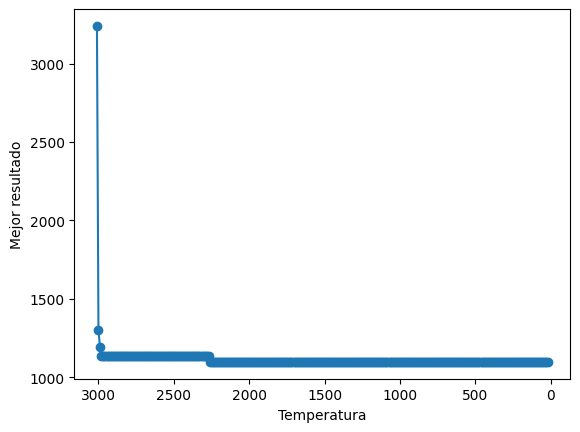

In [62]:

plt.scatter(list(range(T_INICIAL-PASO, T_FINAL, PASO)), list_costo_temp_min)
plt.plot(list(range(T_INICIAL-PASO, T_FINAL, PASO)), list_costo_temp_min)
plt.gca().invert_xaxis()
plt.xlabel("Temperatura")
plt.ylabel("Mejor resultado")
plt.show()

In [63]:
T_INICIAL = 3000
T_FINAL = 10
PASO = -10
ITERACIONES_POR_TEMPERATURA = 50
len(list_tiempo)

8

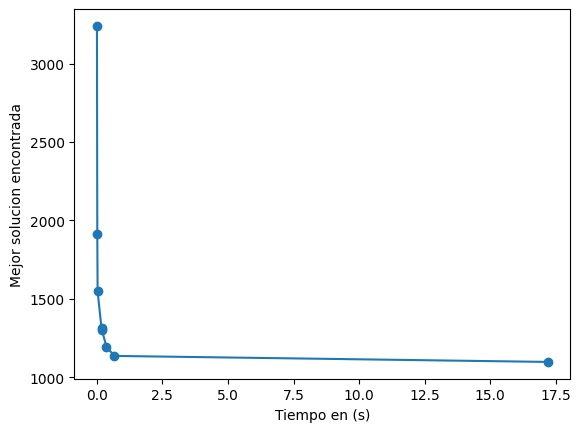

In [64]:
plt.scatter(list_tiempo, list_costo_tiempo_min)
plt.plot(list_tiempo, list_costo_tiempo_min )
plt.xlabel("Tiempo en (s)")
plt.ylabel("Mejor solucion encontrada")
plt.show()

In [66]:

import copy
#HIPERPARÁMETROS DE RECOCIDO SIMULADO
T_INICIAL = 2000
T_FINAL = 10
PASO = -1
ITERACIONES_POR_TEMPERATURA = 10
# clientes_camion,pedidos_no_asignados = generarSolucionInicial(1)
# print(pedidos_no_asignados)
# print(clientes_camion)
pedidos = datos_prueba[5]

def recocidoSimulado(pedidos):
    #INICIALIZACION DE VARIABLES
    clientes_por_camion_min = []
    pedidos_no_asignados_min = []
    costo_por_ton_repartida_min = float('inf')
    pedidos_no_asignados = None
    #pedidos = datos_prueba[1]

    #GENERO LAS SOLUCION INICIAL
    clientes_por_camion, pedidos_no_asignados = generarSolucionInicial(pedidos)
    pedidos_por_camion = pedidosPorCamion(clientes_por_camion, pedidos)
    tons_repartidas_por_camion, tons_no_repartidas = tonsRepartidasPorCamion(pedidos_por_camion = pedidos_por_camion)
    tons_no_asignadas = tonsNoAsignadas(pedidos_no_asignados, pedidos)
    costo_por_camion = costoPorCamion(tons_repartidas_por_camion)
    tons_no_asignadas_o_no_repartidas = tons_no_repartidas + tons_no_asignadas
    #costo_por_camion = costoPorCamion(tons_repartidas_por_camion)
    costo_total = costoTotal(costo_por_camion, tons_no_asignadas_o_no_repartidas)
    tons_repartidas = tonsRepartidas(tons_repartidas_por_camion)
    #CALCULO EL COSTO POR TON REPARTIDA
    costo_por_ton_repartida_1 = costo_total/tons_repartidas
    #print('clientes_por_camion:', clientes_por_camion)
    #print('pedidos_no_asignados:', pedidos_no_asignados)
    clientes_por_camion_1 = clientes_por_camion
    pedidos_no_asignados_1 = pedidos_no_asignados
    clientes_por_camion_min = clientes_por_camion
    pedidos_no_asignados_min = pedidos_no_asignados
    costo_por_ton_repartida_min = costo_por_ton_repartida_1
    #print("costo_por_ton_repartida_min:", costo_por_ton_repartida_min)

    for t in range(T_INICIAL, T_FINAL, PASO):
        #print("-----------------Temperatura:", t,"----------------")
        #print("costo_por_ton_repartida_min", costo_por_ton_repartida_min)
        #print("clientes_por_camion_min:", clientes_por_camion_min)
        #print("pedidos_no_asignados_min:", pedidos_no_asignados_min)
        for n in range(ITERACIONES_POR_TEMPERATURA):
            clientes_por_camion, pedidos_no_asignados = generarVecino1(copy.deepcopy(clientes_por_camion_1), copy.deepcopy(pedidos_no_asignados_1))
            #print("clientes_por_camion:", clientes_por_camion)
            #print("pedidos_no_asignados:", pedidos_no_asignados)
            pedidos_por_camion = pedidosPorCamion(clientes_por_camion, pedidos)
            tons_repartidas_por_camion, tons_no_repartidas = tonsRepartidasPorCamion(pedidos_por_camion = pedidos_por_camion)
            tons_no_asignadas = tonsNoAsignadas(pedidos_no_asignados, pedidos)
            costo_por_camion = costoPorCamion(tons_repartidas_por_camion)
            tons_no_asignadas_o_no_repartidas = tons_no_repartidas + tons_no_asignadas
            #costo_por_camion = costoPorCamion(tons_repartidas_por_camion)
            costo_total = costoTotal(costo_por_camion, tons_no_asignadas_o_no_repartidas)
            tons_repartidas = tonsRepartidas(tons_repartidas_por_camion)
            #CALCULO EL COSTO POR TON REPARTIDA
            costo_por_ton_repartida = costo_total/tons_repartidas
            delta = costo_por_ton_repartida_1 - costo_por_ton_repartida #Calculo delta como Sa - Sb
            if delta < 0 : #Si la solucion nueva es peor que la anterio delta < 0
                p = math.e**(delta/t)
                rand_0_1 = random.random()
                #print("p:",  f"{p:.2f}") 
                #print("rand:", f"{rand_0_1:.2f}")
                if p > rand_0_1 :
                    #ACEPTO UNA PEOR SOLUCION
                    ##print("----Tomo solucion peor---")
                    costo_por_ton_repartida_1 = costo_por_ton_repartida
                    pedidos_no_asignados_1 = pedidos_no_asignados
                    clientes_por_camion_1 = clientes_por_camion
                #else:
                    #SE QUEDA CON LA SOLUCION ANTERIOR
                    # costo_por_ton_repartida_1 = copy.copy(costo_por_ton_repartida_1)
                    # pedidos_no_asignados_1 = pedidos_no_asignados_1[:]
                    # clientes_por_camion_1 = clientes_por_camion_1[:]
            else:
                #ACEPTA LA SOLUCION MEJOR
                #ACA ESTA EL PROBLEMA
                costo_por_ton_repartida_1 = costo_por_ton_repartida
                pedidos_no_asignados_1 = pedidos_no_asignados
                clientes_por_camion_1 = clientes_por_camion

            if costo_por_ton_repartida_min > costo_por_ton_repartida:
                #ACTUALIZA A LA MEJOR SOLUCION HASTA AHORA
                costo_por_ton_repartida_min = costo_por_ton_repartida
                clientes_por_camion_min = clientes_por_camion
                pedidos_no_asignados_min = pedidos_no_asignados
            # #print("costo_por_ton_repartida:",costo_por_ton_repartida)
            # print("costo_por_ton_repartida_1:", costo_por_ton_repartida_1)
            # print("clientes_por_camion:", clientes_por_camion)
            # print("Pedidos_no_asignados:", pedidos_no_asignados)
            # print("clientes_por_camion_1:", clientes_por_camion_1)
            # print("pedidos_no_asignados_1:", pedidos_no_asignados_1)


    return costo_por_ton_repartida_min, clientes_por_camion_min, pedidos_no_asignados_min

In [67]:
T_INICIAL = 2000
T_FINAL = 100
PASO = -10
ITERACIONES_POR_TEMPERATURA = 50

pedidos = datos_prueba[8]
costo_por_ton_repartida_min, clientes_por_camion_min, pedidos_no_asignados_min = recocidoSimulado(pedidos)
print(costo_por_ton_repartida_min)
print(clientes_por_camion_min)
print(pedidos_no_asignados_min)

1220.5882352941176
[['F', 'G'], ['L', 'I'], ['N', 'E', 'M'], ['K', 'H'], ['A', 'O'], ['J', 'B', 'D']]
['C']


In [68]:
resultados = []
for i in range(1,10):
    pedidos = datos_prueba[i]
    costo_por_ton_repartida_min, clientes_por_camion_min, pedidos_no_asignados_min = recocidoSimulado(pedidos)
    resultados.append(costo_por_ton_repartida_min)
print(resultados)


[1119.1489361702127, 1070.3703703703704, 1072.7272727272727, 1053.5714285714287, 1121.875, 1022.9508196721312, 1049.122807017544, 1220.5882352941176, 1116.923076923077]


In [ ]:
# resultadosCalibracion = []
# PASO = -10
# ITERACIONES_POR_TEMPERATURA = 10

# for T_INICIAL in range(2000, 1000, -100): #TEMPERATURA INICIAL 10
#     res_T_Final = []
#     for T_FINAL in range(210, 10, -25): #TEMPERATURA FINAL 8
#                 corrida = []
#                 for i in range(10):
#                     costo_por_ton_repartida_min, clientes_por_camion_min, pedidos_no_asignados_min = recocidoSimulado(pedidos)
#                     corrida.append(costo_por_ton_repartida_min)
#                 res_T_Final.append(corrida)
#     resultadosCalibracion.append(res_T_Final)

In [ ]:
# # resultadosCalibracion
# promedio_calibracion = []
# for  i in range(0,10):
#     list_i = []
#     for j in range(0,8):
#         list_i.append(statistics.mean(resultadosCalibracion[i][j]))
#     promedio_calibracion.append(list_i)

# promedio_calibracion



In [ ]:
# df_result_calibracion = pd.DataFrame(promedio_calibracion)
# df_result_calibracion = df_result_calibracion.astype(int)
# df_result_calibracion



In [ ]:
# import seaborn as sns
# # sns.heatmap(df_result_calibracion, annot = True, fmt= 'd')

In [ ]:
# ton_prom = []

# for i in range(1000):
#     clientes_por_camion_min = []
#     pedidos_no_asignados_min = []
#     costo_por_ton_repartida_min = float('inf')
#     pedidos_no_asignados = None
#     #pedidos = datos_prueba[1]

#     #GENERO LAS SOLUCION INICIAL
#     clientes_por_camion, pedidos_no_asignados = generarSolucionInicial(pedidos)
#     pedidos_por_camion = pedidosPorCamion(clientes_por_camion, pedidos)
#     tons_repartidas_por_camion, tons_no_repartidas = tonsRepartidasPorCamion(pedidos_por_camion = pedidos_por_camion)
#     tons_no_asignadas = tonsNoAsignadas(pedidos_no_asignados, pedidos)
#     costo_por_camion = costoPorCamion(tons_repartidas_por_camion)
#     tons_no_asignadas_o_no_repartidas = tons_no_repartidas + tons_no_asignadas
#     #costo_por_camion = costoPorCamion(tons_repartidas_por_camion)
#     costo_total = costoTotal(costo_por_camion, tons_no_asignadas_o_no_repartidas)
#     tons_repartidas = tonsRepartidas(tons_repartidas_por_camion)
#     #CALCULO EL COSTO POR TON REPARTIDA
#     costo_por_ton_repartida_1 = costo_total/tons_repartidas
#     #print('clientes_por_camion:', clientes_por_camion)
#     #print('pedidos_no_asignados:', pedidos_no_asignados)
#     clientes_por_camion_1 = clientes_por_camion
#     pedidos_no_asignados_1 = pedidos_no_asignados
#     clientes_por_camion_min = clientes_por_camion
#     pedidos_no_asignados_min = pedidos_no_asignados
#     costo_por_ton_repartida_min = costo_por_ton_repartida_1
#     #print("costo_por_ton_repartida_min:", costo_por_ton_repartida_min)
#     ton_prom.append(costo_por_ton_repartida_min)

In [ ]:
# ton_prom_1 = ton_prom[1:]
# ton_prom_2 = ton_prom[:999]
# ton_prom = np.array(ton_prom)
# ton_prom_1 = np.array(ton_prom_1)
# ton_prom_2 = np.array(ton_prom_2)
# ton_dif = ton_prom_2 - ton_prom_1

# print(np.abs(ton_dif).mean())
# ton_prom.std()

In [70]:
def opt_2(cpc):
    #ELIJO 2 CAMIONES DIFERENTES AL AZAR
    #genero 2 numeros al azar diferentes
    rand1 = random.randint(0, CANTIDAD_DE_CAMIONES-1)
    while True:
        rand2 = random.randint(0, CANTIDAD_DE_CAMIONES-1)
        if rand1 != rand2:
            break
    #genero los 2 camiones
    camion_1 = cpc[rand1]
    camion_2 = cpc[rand2]

    #SELECCIONO UN CLIENTE AL AZAR DE CADA CAMION
    rand_cliente_1 = random.randint(0, len(camion_1) - 1 )
    rand_cliente_2 = random.randint(0, len(camion_2) - 1 )

    #Elimino el cliente del camion    
    cliente_2 = camion_1.pop(rand_cliente_1)
    cliente_1 = camion_2.pop(rand_cliente_2)

    #Verifico que se puedan poner uno en cada lugar]
    #Pruebo si puedo meter al cliente_1 en el camion_2
    llega_list_1 = []
    for cliente in camion_2:
        llega_1 = df_llega.loc[cliente,cliente_2]
        llega_list_1.append(llega_1)
    llega_todos_1 = all(llega_list_1)
    
    llega_list_2 = []
    for cliente in camion_1:
        llega_2 = df_llega.loc[cliente,cliente_1]
        llega_list_2.append(llega_2)
    llega_todos_2 = all(llega_list_2)

    #Si tanto el cliente_1 y el cliente_2 estan a menos de 2km de los otros clientes del camion los asigno cruzo y si no los dejo como estaban
    if(llega_todos_1 and llega_todos_2):
        #Los asigno cruzados
        camion_1.append(cliente_1)
        camion_2.append(cliente_2)
    else:
        #Los dejo como estaban
        camion_1.append(cliente_2)
        camion_2.append(cliente_1)


    #Retorno los clientes por camion
    return cpc

In [124]:
def opt_2_bis(cpc, cna, costo_min, pedidos):
    cpc_min = copy.deepcopy(cpc)
    todos_camiones_con_pedidos = all(cpc)
    if not todos_camiones_con_pedidos:
        return cpc, costo_min
    #RECORRO TODOS LOS CAMIONES
    for i in range(CANTIDAD_DE_CAMIONES):
        camion_1 = cpc[i]
        len_camion_1 = len(camion_1)

        #RECORRO TODOS LOS CAMIONES PERO CAMION_1<CAMION_2
        for j in range(i+1,CANTIDAD_DE_CAMIONES):
            camion_2 = cpc[j]
            len_camion_2 = len(camion_2)
            
            #RECORRO TODOS LOS CLIENTES DEL CAMION_1
            for k in range(len_camion_1):
                cliente_1 = copy.deepcopy(camion_1[k])


                #GENERO EL ITERABLE PARA EL CLIENTE_2 SOBRE EL CAMION_1
                # cm =  [m for m in range(0, len_camion_1) if m != k]

                #RECORRO TODOS LOS CLIENTES DEL CAMION_2
                for l in range(len_camion_2):
                    cliente_2 = copy.deepcopy(camion_2[l])
                    
                    #GENERO EL ITERABLE PARA EL CLIENTE_1
                    cn = [n for n in range(0,len_camion_2) if n != l]
                    
                    #QUIERO METER AL CLIENTE_1 EN EL CAMION_2
                        #ME FIJO SI DA LA DISTANCIA PARA TODOS LOS CLIENTES QUE HAY EN CAMION_2 MENOS CON EL QUE VOY A INTERCAMBIA (CLIENTE_2)
                    llega_list_1 =[]
                    for n in cn:
                        cliente = camion_2[n]
                        llega_1 = df_llega.loc[cliente_1,cliente]
                        llega_list_1.append(llega_1)
                    
                    llega_todos_1 = all(llega_list_1) #Chequea que sean todos true
                    
                    #SI EL CLIENTE_1 ES COMPATIBLE CON LOS CLIENTES DEL CAMION_2 PRUEBO EL CLIENTE_2 EN EL CAMION_1
                    if(llega_todos_1):

                        cm = [n for n in range(0, len_camion_1) if n != k]
                        llega_list_2 = []
                        
                        for m in cm:
                            cliente = camion_1[m]
                            llega_2 = df_llega.loc[cliente_2, cliente]
                            llega_list_2.append(llega_2)
                        llega_todos_2 = all(llega_list_2)
                        
                        
                        #SI EL CLIENTE_2 ENTRA EN EL CAMION_1 LOS CAMBIO
                        if(llega_todos_2):
                            print("----llega todos entra al if----")
                            print(cpc)
                            print("camion_1:", i)
                            print("camion_2:", j)
                            print("k:", k)
                            print("j:", l)
                            print("cliente_1 a mover:", camion_1[k])
                            print("cliente_2 a mover:", camion_2[l])
                            del camion_1[k]
                            del camion_2[l]

                            camion_1.insert(k,cliente_2)
                            camion_2.insert(j,cliente_1)

                            #CALCULAR COSTO
                            costo = calcularCostoPorTon(cpc, cna, pedidos)
                            print("Clientes cambiados:", cpc)
                            #IF COSTO_MIN < COSTO
                            if costo_min > costo:
                                cpc_min = copy.deepcopy(cpc)
                                costo_min = costo                                

                            del camion_1[k]
                            del camion_2[l]

                            camion_1.insert(k,cliente_1)
                            camion_2.insert(l,cliente_2)
                            print("----rearma los clientes al original----")
                            print(cpc)

    #Retorno los clientes por camion
    return cpc_min, costo_min

In [ ]:
#############################################################################################
#---------------Copiado de chat GPT---------------------------

def opt_2_bis(cpc, cna, costo_min, pedidos):
    cpc_min = copy.deepcopy(cpc)
    todos_camiones_con_pedidos = all(cpc)
    if not todos_camiones_con_pedidos:
        return cpc, costo_min
    # RECORRO TODOS LOS CAMIONES
    for i in range(CANTIDAD_DE_CAMIONES):
        camion_1 = cpc[i]
        len_camion_1 = len(camion_1)

        # RECORRO TODOS LOS CAMIONES PERO CAMION_1 < CAMION_2
        for j in range(i + 1, CANTIDAD_DE_CAMIONES):
            camion_2 = cpc[j]
            len_camion_2 = len(camion_2)

            # RECORRO TODOS LOS CLIENTES DEL CAMION_1
            for k in range(len_camion_1):
                cliente_1 = copy.deepcopy(camion_1[k])

                # GENERO EL ITERABLE PARA EL CLIENTE_2 SOBRE EL CAMION_1
                cm = [m for m in range(0, len_camion_1 - 1) if m != k]

                # RECORRO TODOS LOS CLIENTES DEL CAMION_2
                for l in range(len_camion_2):
                    cliente_2 = copy.deepcopy(camion_2[l])

                    # GENERO EL ITERABLE PARA EL CLIENTE_1
                    cn = [n for n in range(0, len(camion_2)) if n != l]

                    # QUIERO METER AL CLIENTE_1 EN EL CAMION_2
                    # ME FIJO SI DA LA DISTANCIA PARA TODOS LOS CLIENTES QUE HAY EN CAMION_2 MENOS CON EL QUE VOY A INTERCAMBIAR (CLIENTE_2)
                    llega_list_1 = []
                    for n in cn:
                        cliente = camion_2[n]
                        llega_1 = df_llega.loc[cliente_1, cliente]
                        llega_list_1.append(llega_1)

                    llega_todos_1 = all(llega_list_1)  # Chequea que sean todos true

                    # SI EL CLIENTE_1 ES COMPATIBLE CON LOS CLIENTES DEL CAMION_2 PRUEBO EL CLIENTE_2 EN EL CAMION_1
                    if llega_todos_1:
                        cn = [n for n in range(0, len(camion_1)) if n != k]
                        llega_list_2 = []

                        for m in cm:
                            cliente = camion_1[m]
                            llega_2 = df_llega.loc[cliente_2, cliente]
                            llega_list_2.append(llega_2)
                        llega_todos_2 = all(llega_list_2)

                        # SI EL CLIENTE_2 ENTRA EN EL CAMION_1 LOS CAMBIO
                        if llega_todos_2:
                            print("----llega todos entra al if----")
                            print(cpc)
                            print("camion_1:", i)
                            print("camion_2:", j)
                            print("k:", k)


In [76]:
clientes_por_camion = [['O', 'J'],['M', 'K', 'I'], ['F', 'H', 'B'], ['N', 'G', 'E'], ['L', 'A'], ['C', 'D']]
print(opt_2(clientes_por_camion))

[['O', 'J'], ['K', 'I', 'M'], ['F', 'H', 'B'], ['N', 'G', 'E'], ['L', 'A'], ['D', 'C']]


In [ ]:
cpc = [['K', 'N'], ['F', 'E', 'G'], ['I', 'A'], ['L', 'D', 'C'], ['H', 'B'], ['M']]


In [123]:
pedidos = datos_prueba[1]
recocidoSimulado1(pedidos)

([['D', 'E'], ['K', 'I'], ['G', 'J'], ['L', 'A'], ['H'], ['F', 'B', 'C']],
 [],
 1127.659574468085,
 [2042.1052631578948,
  1302.2222222222222,
  1302.2222222222222,
  1302.2222222222222,
  1302.2222222222222,
  1302.2222222222222,
  1161.7021276595744,
  1161.7021276595744,
  1161.7021276595744,
  1161.7021276595744,
  1161.7021276595744,
  1161.7021276595744,
  1161.7021276595744,
  1161.7021276595744,
  1161.7021276595744,
  1161.7021276595744,
  1161.7021276595744,
  1161.7021276595744,
  1161.7021276595744,
  1140.4255319148936,
  1140.4255319148936,
  1140.4255319148936,
  1140.4255319148936,
  1140.4255319148936,
  1140.4255319148936,
  1140.4255319148936,
  1140.4255319148936,
  1140.4255319148936,
  1140.4255319148936,
  1140.4255319148936,
  1140.4255319148936,
  1140.4255319148936,
  1140.4255319148936,
  1140.4255319148936,
  1140.4255319148936,
  1140.4255319148936,
  1140.4255319148936,
  1140.4255319148936,
  1140.4255319148936,
  1140.4255319148936,
  1140.4255319148936

[['C'], ['H', 'E', 'J'], ['G'], ['L', 'K'], ['I', 'B'], ['F', 'D', 'A']]

In [125]:
cpc = [['A'], ['H', 'E', 'J'], ['G'], ['L', 'K'], ['I', 'B'], ['F', 'C', 'D']]
cpc = [['D', 'E'], ['K', 'I'], ['G', 'J'], ['L', 'A'], ['H'], ['F', 'B', 'C']]
costo = 1119.1489361702127
costo = 1127.659574468085
cna = []


clpc, costo_min = opt_2_bis(cpc, cna, costo, pedidos)
print(clpc)
print(costo_min)

----llega todos entra al if----
[['D', 'E'], ['K', 'I'], ['G', 'J'], ['L', 'A'], ['H'], ['F', 'B', 'C']]
camion_1: 0
camion_2: 2
k: 0
j: 0
cliente_1 a mover: D
cliente_2 a mover: G
Clientes cambiados: [['G', 'E'], ['K', 'I'], ['J', 'D'], ['L', 'A'], ['H'], ['F', 'B', 'C']]
----rearma los clientes al original----
[['D', 'E'], ['K', 'I'], ['G', 'D'], ['L', 'A'], ['H'], ['F', 'B', 'C']]
----llega todos entra al if----
[['D', 'E'], ['K', 'I'], ['G', 'D'], ['L', 'A'], ['H'], ['F', 'B', 'C']]
camion_1: 0
camion_2: 2
k: 1
j: 1
cliente_1 a mover: E
cliente_2 a mover: D
Clientes cambiados: [['D', 'D'], ['K', 'I'], ['G', 'E'], ['L', 'A'], ['H'], ['F', 'B', 'C']]
----rearma los clientes al original----
[['D', 'E'], ['K', 'I'], ['G', 'D'], ['L', 'A'], ['H'], ['F', 'B', 'C']]
----llega todos entra al if----
[['D', 'E'], ['K', 'I'], ['G', 'D'], ['L', 'A'], ['H'], ['F', 'B', 'C']]
camion_1: 0
camion_2: 3
k: 0
j: 1
cliente_1 a mover: D
cliente_2 a mover: A
Clientes cambiados: [['A', 'E'], ['K', 'I'], 

In [126]:
clpc, costo_min = opt_2_bis(cpc, cna, costo_min, pedidos)
print(clpc)
print(costo_min)

----llega todos entra al if----
[['D', 'E'], ['K', 'I'], ['G', 'I'], ['L', 'G'], ['H'], ['F', 'L', 'H']]
camion_1: 0
camion_2: 2
k: 0
j: 0
cliente_1 a mover: D
cliente_2 a mover: G
Clientes cambiados: [['G', 'E'], ['K', 'I'], ['I', 'D'], ['L', 'G'], ['H'], ['F', 'L', 'H']]
----rearma los clientes al original----
[['D', 'E'], ['K', 'I'], ['G', 'D'], ['L', 'G'], ['H'], ['F', 'L', 'H']]
----llega todos entra al if----
[['D', 'E'], ['K', 'I'], ['G', 'D'], ['L', 'G'], ['H'], ['F', 'L', 'H']]
camion_1: 0
camion_2: 2
k: 1
j: 1
cliente_1 a mover: E
cliente_2 a mover: D
Clientes cambiados: [['D', 'D'], ['K', 'I'], ['G', 'E'], ['L', 'G'], ['H'], ['F', 'L', 'H']]
----rearma los clientes al original----
[['D', 'E'], ['K', 'I'], ['G', 'D'], ['L', 'G'], ['H'], ['F', 'L', 'H']]
----llega todos entra al if----
[['D', 'E'], ['K', 'I'], ['G', 'D'], ['L', 'G'], ['H'], ['F', 'L', 'H']]
camion_1: 0
camion_2: 3
k: 0
j: 1
cliente_1 a mover: D
cliente_2 a mover: G
Clientes cambiados: [['G', 'E'], ['K', 'I'], 